In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
from collections import namedtuple, deque
import torch.optim as optim
import gym
from gym import spaces
import scipy.linalg
import cvxpy as cp

# Final version of LQISupervisor for incremental TD3+LQI setup

class LQISupervisor:
    def __init__(self, A, B, C, Q_aug, R, delta_bounds=(-0.5, 0.5)):
        self.delta_min, self.delta_max = delta_bounds
        self.K_aug = self._compute_lqi_gain(A, B, C, Q_aug, R)

    def _compute_lqi_gain(self, A, B, C, Q_aug, R):
        n = A.shape[0]
        A_aug = np.zeros((n + 1, n + 1))
        A_aug[:n, :n] = A
        A_aug[:n, n] = B.flatten() * -1.0
        A_aug[n, :n] = -C

        B_aug = np.zeros((n + 1, 1))
        B_aug[:n, :] = B.reshape(-1, 1)

        P = scipy.linalg.solve_continuous_are(A_aug, B_aug, Q_aug, R)
        K_aug = np.linalg.inv(R) @ B_aug.T @ P
        return K_aug

    def get_lqi_action(self, state, integral_error):
        x_aug = np.concatenate([state, [integral_error]])
        # return float(-self.K_aug @ x_aug)
        return (-self.K_aug @ x_aug).item()


    def get_safe_action(self, u_rl, state, q_ref, integral_error):
        u_lqi = self.get_lqi_action(state, integral_error)

        # TD3 correction bounded to small safe values
        delta_rl = u_rl - u_lqi
        delta_clipped = np.clip(delta_rl, -0.02, 0.02)

        # Final action is LQI + TD3 delta, bounded to actuator limits
        u_safe = np.clip(u_lqi + delta_clipped, -0.5, 0.5)
        return float(u_safe)



class ShortPeriodAircraftContinuousEnv(gym.Env):
    def __init__(self):
        super().__init__()

        # System Dynamics
        self.A = np.array([[-11.0104, -2.3366],
                           [-1.4787,   0.9757]])
        self.B = np.array([-0.1501, -18.3881])
        self.C = np.array([[0.0, 1.0]])  # Output matrix for pitch rate q
        self.dt = 0.02

        # Observation: [delta_q, delta_e]
        self.observation_space = spaces.Box(
            low=np.array([-1.0, -0.5], dtype=np.float32),
            high=np.array([1.0,  0.5], dtype=np.float32),
            dtype=np.float32
        )

        self.action_space = spaces.Box(
            low=np.array([-0.02], dtype=np.float32),  # delta(delta_e)
            high=np.array([0.02], dtype=np.float32),
            dtype=np.float32
        )

        # Supervisor with LQI
        Q_aug = np.diag([0.0, 0.0, 1.0])
        R = np.array([[1.0]])
        self.lqi_supervisor = LQISupervisor(self.A, self.B, self.C, Q_aug, R, delta_bounds=(-0.5, 0.5))

        self.alpha = 0.0
        self.q = 0.0
        self.prev_delta_e = 0.0
        self.integral_error = 0.0
        self.current_step = 0
        self.max_steps = 1000

    def q_ref_square_wave(self, t):
        period = 10.0
        high_value = 0.15
        low_value = -0.15
        cycle_time = t % period
        return high_value if cycle_time < 5.0 else low_value

    def q_ref_composite(self, t):
        base = 0.1 if (t % 10) < 5 else -0.1
        noise = 0.05 * np.sin(2 * np.pi * 0.5 * t)
        return base + noise



    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.alpha = 0.0
        self.q = 0.0
        self.prev_delta_e = 0.0
        self.integral_error = 0.0
        self.current_step = 0

        # q_ref = 0.15 * np.sin(2 * np.pi * 0.15 * self.current_step * self.dt)
        t = self.current_step * self.dt
        q_ref = self.q_ref_square_wave(t)
        # q_ref = self.q_ref_composite(t)

        delta_q = self.q - q_ref
        delta_e = self.prev_delta_e

        obs = np.array([delta_q, delta_e], dtype=np.float32)
        return obs, {}

    def step(self, delta_delta_e):
        delta_delta_e = float(np.clip(delta_delta_e, -0.02, 0.02))
        # q_ref = 0.15 * np.sin(2 * np.pi * 0.15 * self.current_step * self.dt)
        t = self.current_step * self.dt
        q_ref = self.q_ref_square_wave(t)
        # q_ref = self.q_ref_composite(t)

        # Update integral error
        self.integral_error += (q_ref - self.q) * self.dt

        # Compute safe control action using supervisor
        state = np.array([self.alpha, self.q])
        u_safe = self.lqi_supervisor.get_safe_action(delta_delta_e, state, q_ref, self.integral_error)

        # Apply dynamics
        state_dot = self.A @ state + self.B * u_safe
        self.alpha += state_dot[0] * self.dt
        self.q     += state_dot[1] * self.dt

        self.alpha = np.clip(self.alpha, -1.0, 1.0)
        self.q     = np.clip(self.q, -1.0, 1.0)

        self.prev_delta_e = u_safe
        self.current_step += 1

        delta_q = self.q - q_ref
        obs = np.array([delta_q, self.prev_delta_e], dtype=np.float32)
        reward = -(10.0 * delta_q**2 + 1.0 * u_safe**2)

        terminated = bool(abs(self.alpha) > 2.0 or abs(self.q) > 2.0)
        truncated = bool(self.current_step >= self.max_steps)

        info = {
            "q_ref": q_ref,
            "delta_q": delta_q,
            "q": self.q,
            "delta_e": u_safe,
            "u_lqi": self.lqi_supervisor.get_lqi_action(state, self.integral_error)
        }

        return obs, reward, terminated, truncated, info





In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_sizes=[128, 64], final_gain=0.01):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], action_size)

        # Apply orthogonal initialization
        self.apply(lambda m: self.orthogonal_init(m, final_gain=final_gain))

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # Assumes actions scaled to [-1, 1]
        return x

    @staticmethod
    def orthogonal_init(layer, gain=1.0, final_gain=0.01):
        if isinstance(layer, nn.Linear):
            if layer.out_features == 1 or layer.out_features < 10:
                torch.nn.init.orthogonal_(layer.weight, gain=final_gain)
            else:
                torch.nn.init.orthogonal_(layer.weight, gain=gain)
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)


class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_sizes=[128, 64], final_gain=0.01):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        # State and action go together in the second layer
        self.fc1 = nn.Linear(state_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0] + action_size, hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], 1)

        # Apply orthogonal initialization
        self.apply(lambda m: self.orthogonal_init(m, final_gain=final_gain))

    def forward(self, state, action):
        x = F.relu(self.fc1(state))
        x = torch.cat((x, action), dim=1)  # Concatenate along features
        x = F.relu(self.fc2(x))
        q = self.fc3(x)  # Output Q-value
        return q

    @staticmethod
    def orthogonal_init(layer, gain=1.0, final_gain=0.01):
        if isinstance(layer, nn.Linear):
            if layer.out_features == 1 or layer.out_features < 10:
                torch.nn.init.orthogonal_(layer.weight, gain=final_gain)
            else:
                torch.nn.init.orthogonal_(layer.weight, gain=gain)
            if layer.bias is not None:
                torch.nn.init.zeros_(layer.bias)




In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class AgentCAPS_TD3():
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.learn_step = 0
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local_1 = Critic(state_size, action_size, random_seed).to(device)
        self.critic_local_2 = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target_1 = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target_2 = Critic(state_size, action_size, random_seed).to(device)

        self.critic_optimizer_1 = optim.Adam(self.critic_local_1.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic_optimizer_2 = optim.Adam(self.critic_local_2.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

        self.lambda_t = 5e-3
        self.lambda_s = 1e-3

    def step(self, states, actions, rewards, next_states, dones):
        for i in range(self.num_agents):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])

        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        with torch.no_grad():
            actions_next = self.actor_target(next_states)
            noise = (torch.randn_like(actions_next) * POLICY_NOISE).clamp(-NOISE_CLIP, NOISE_CLIP)
            actions_next = (actions_next + noise).clamp(-1, 1)

            Q_target1_next = self.critic_target_1(next_states, actions_next)
            Q_target2_next = self.critic_target_2(next_states, actions_next)
            Q_targets_next = torch.min(Q_target1_next, Q_target2_next)
            Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected1 = self.critic_local_1(states, actions)
        Q_expected2 = self.critic_local_2(states, actions)

        critic_loss1 = F.mse_loss(Q_expected1, Q_targets)
        critic_loss2 = F.mse_loss(Q_expected2, Q_targets)

        self.critic_optimizer_1.zero_grad()
        critic_loss1.backward()
        self.critic_optimizer_1.step()

        self.critic_optimizer_2.zero_grad()
        critic_loss2.backward()
        self.critic_optimizer_2.step()

        self.learn_step += 1
        if self.learn_step % POLICY_DELAY == 0:
            actions_pred = self.actor_local(states)
            actor_loss = -self.critic_local_1(states, actions_pred).mean()

            # CAPS temporal smoothness
            actions_pred_next = self.actor_local(next_states)
            temporal_loss = F.mse_loss(actions_pred_next, actions_pred)

            # CAPS spatial consistency
            noise = torch.normal(mean=0.0, std=0.01, size=states.shape).to(device)
            perturbed_states = states + noise
            actions_perturbed = self.actor_local(perturbed_states)
            spatial_loss = F.mse_loss(actions_pred, actions_perturbed)

            # Total actor loss with CAPS
            actor_loss += self.lambda_t * temporal_loss + self.lambda_s * spatial_loss

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            self.soft_update(self.critic_local_1, self.critic_target_1, TAU)
            self.soft_update(self.critic_local_2, self.critic_target_2, TAU)
            self.soft_update(self.actor_local, self.actor_target, TAU)

    def act(self, states, add_noise=True):
        states = torch.from_numpy(states).float().to(device)
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        if add_noise:
            actions += np.random.normal(0, ACT_NOISE, size=actions.shape)
        return np.clip(actions, -1, 1)

    def reset(self):
        pass

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)


In [11]:
from collections import deque
import numpy as np

def scale_action(delta_action, max_rate=0.1):
    return np.clip(delta_action, -1.0, 1.0) * max_rate

def TD3(n_episodes=200, max_t=1000, print_every=1):
    scores = []
    scores_deque = deque(maxlen=print_every)

    best_reward = -np.inf
    best_q_vals = []
    best_q_refs = []
    best_delta_qs = []
    best_delta_es = []
    best_td3_actions = []
    best_lqi_actions = []


    good_episode_streak = 0

    try:
        for i_episode in range(1, n_episodes + 1):
            obs, info = env.reset()
            state = obs
            agent.reset()
            total_reward = 0

            episode_q_vals = []
            episode_q_refs = []
            episode_delta_qs = []
            episode_delta_es = []
            episode_td3_actions = []
            episode_lqi_actions = []


            steps_run = 0
            prev_delta_e = 0.0

            for t in range(max_t):
                steps_run += 1
                state_input = np.array(state, dtype=np.float32).reshape(1, -1)
                delta_action = agent.act(state_input)
                delta_rate = scale_action(delta_action, max_rate=1.0).flatten()[0]
                delta_e = prev_delta_e + delta_rate * env.dt
                delta_e = np.clip(delta_e, -0.5, 0.5)
                prev_delta_e = delta_e

                next_obs, reward, terminated, truncated, info = env.step(delta_e)
                done = terminated or truncated

                q = info.get("q", 0.0)
                q_ref = info.get("q_ref", 0.0)
                delta_q = info.get("delta_q", 0.0)
                applied_delta_e = info.get("delta_e", delta_e)
                u_lqi = info.get("u_lqi", 0.0)


                episode_q_vals.append(q)
                episode_q_refs.append(q_ref)
                episode_delta_qs.append(delta_q)
                episode_delta_es.append(applied_delta_e)
                episode_td3_actions.append(delta_e)
                episode_lqi_actions.append(u_lqi)

                next_state = np.array([delta_q, applied_delta_e], dtype=np.float32)

                agent.step(state_input, delta_action, np.array([reward]),
                           np.array([next_state]), np.array([done]))

                state = next_state
                total_reward += reward

                if done:
                    break

            scores.append(total_reward)
            scores_deque.append(total_reward)
            avg_reward = np.mean(scores_deque)
            print(f"\rEpisode {i_episode}/{n_episodes}\tSteps: {steps_run}\tReward: {total_reward:.2f}\tAverage Reward: {avg_reward:.2f}", end="")
            if i_episode % print_every == 0:
                print("")

            if t == max_t - 1 and total_reward > best_reward:
                best_reward = total_reward
                best_q_vals = episode_q_vals.copy()
                best_q_refs = episode_q_refs.copy()
                best_delta_qs = episode_delta_qs.copy()
                best_delta_es = episode_delta_es.copy()
                best_td3_actions = episode_td3_actions.copy()
                best_lqi_actions = episode_lqi_actions.copy()

            if not done and total_reward > -1:
                good_episode_streak += 1
            else:
                good_episode_streak = 0

            if good_episode_streak >= 5:
                print(f"\nEarly stopping after {i_episode} episodes — 5 consecutive good full-length episodes.")
                break

    except KeyboardInterrupt:
        print(f"\nTraining manually interrupted at episode {i_episode}.")

    return scores, best_q_vals, best_q_refs, best_delta_qs, best_delta_es, best_reward, best_td3_actions, best_lqi_actions


Episode 1/200	Steps: 1000	Reward: -100.26	Average Reward: -100.26
Episode 2/200	Steps: 1000	Reward: -56.07	Average Reward: -56.07
Episode 3/200	Steps: 1000	Reward: -54.80	Average Reward: -54.80
Episode 4/200	Steps: 1000	Reward: -54.80	Average Reward: -54.80
Episode 5/200	Steps: 1000	Reward: -55.09	Average Reward: -55.09
Episode 6/200	Steps: 1000	Reward: -55.04	Average Reward: -55.04
Episode 7/200	Steps: 1000	Reward: -55.02	Average Reward: -55.02
Episode 8/200	Steps: 1000	Reward: -54.73	Average Reward: -54.73
Episode 9/200	Steps: 1000	Reward: -54.86	Average Reward: -54.86
Episode 10/200	Steps: 1000	Reward: -54.67	Average Reward: -54.67
Episode 11/200	Steps: 1000	Reward: -54.71	Average Reward: -54.71
Episode 12/200	Steps: 1000	Reward: -54.71	Average Reward: -54.71
Episode 13/200	Steps: 1000	Reward: -54.78	Average Reward: -54.78
Episode 14/200	Steps: 1000	Reward: -55.03	Average Reward: -55.03
Episode 15/200	Steps: 1000	Reward: -54.74	Average Reward: -54.74
Episode 16/200	Steps: 1000	Rewar

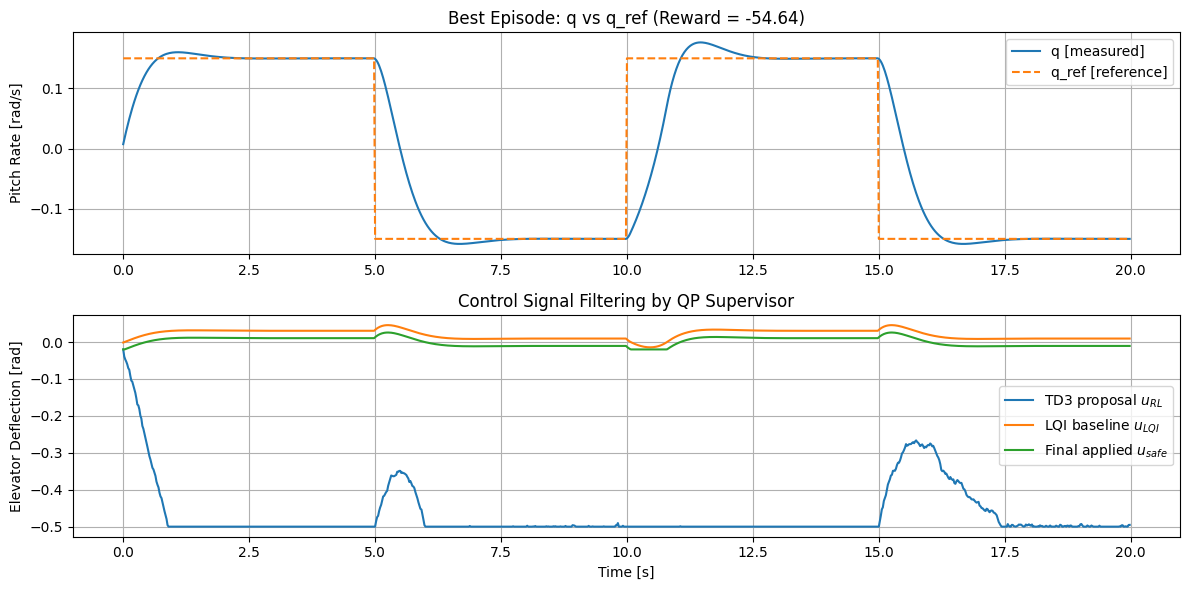

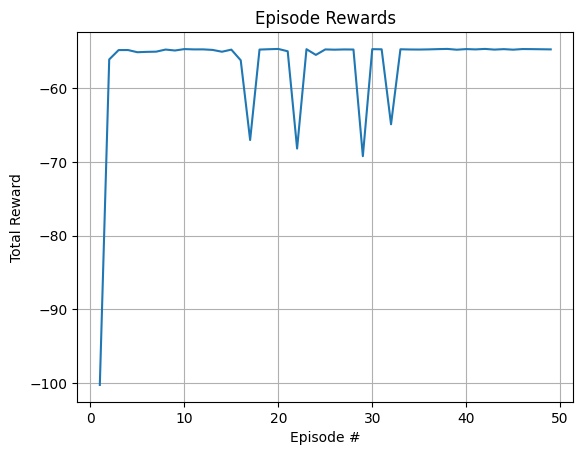

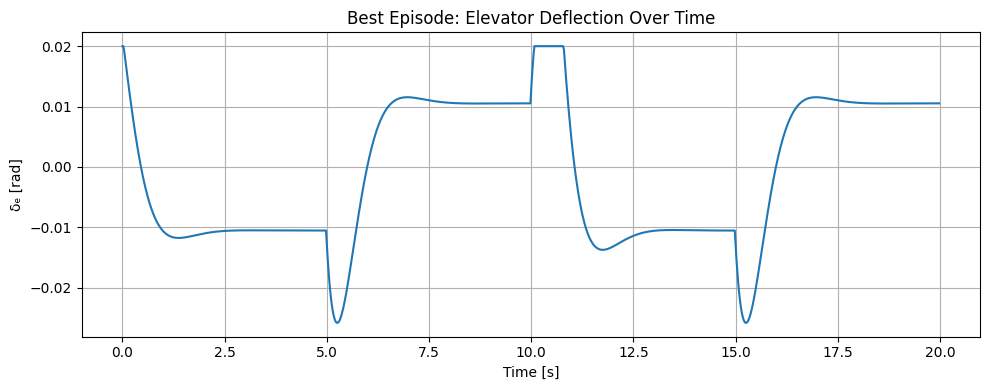

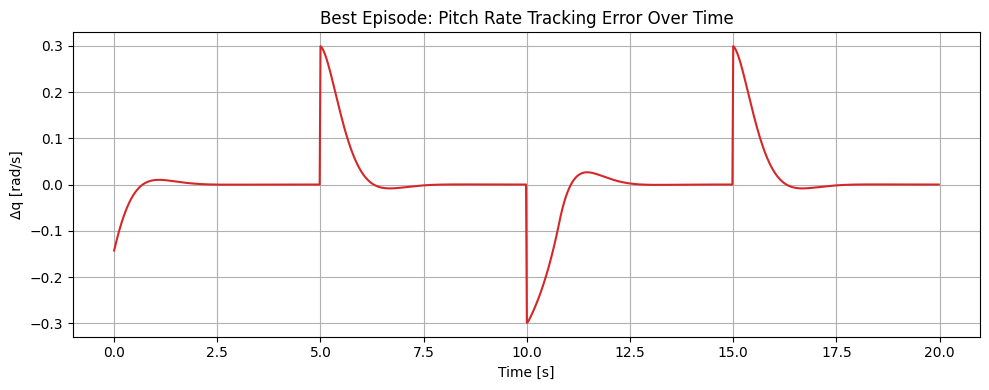

In [12]:
# Parameters for TD3 + CAPS
BUFFER_SIZE = int(1e5)   # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.97             # discount factor (or 0.98 if long horizons needed)
TAU = 5e-4               # target network soft update (or 1e-3 if faster updates needed)
LR_ACTOR = 1e-4          # actor learning rate
LR_CRITIC = 1e-3         # critic learning rate (NOT 5e-3!)
WEIGHT_DECAY = 0         # no L2 regularization
POLICY_NOISE = 0.3       # TD3 target policy noise
NOISE_CLIP = 0.5         # clip noise
POLICY_DELAY = 2         # update actor every 2 critic updates
ACT_NOISE = 0.2         # smaller exploration noise for incremental control


env = ShortPeriodAircraftContinuousEnv()
state_size = env.observation_space.shape[0]  # or just 1
action_size = env.action_space.shape[0]      # or just 1


agent = AgentCAPS_TD3(state_size, action_size, num_agents=1, random_seed=1210)


# We call the TD3 function, and we start learning:

# scores, best_q_vals, best_q_refs, best_delta_qs, best_delta_es, best_reward = TD3()

# Re-import necessary libraries after state reset
import matplotlib.pyplot as plt

def plot_qp_supervision_diagnostics(q_vals, q_refs, td3_actions, lqi_actions, safe_actions, delta_ts, best_reward):
    """
    Plots tracking performance and QP supervision filtering of control inputs.
    """
    time = [t * delta_ts for t in range(len(q_vals))]

    plt.figure(figsize=(12, 6))

    # Plot q vs q_ref
    plt.subplot(2, 1, 1)
    plt.plot(time, q_vals, label="q [measured]")
    plt.plot(time, q_refs, "--", label="q_ref [reference]")
    plt.ylabel("Pitch Rate [rad/s]")
    plt.title(f"Best Episode: q vs q_ref (Reward = {best_reward:.2f})")
    plt.legend()
    plt.grid(True)

    # Plot control actions
    plt.subplot(2, 1, 2)
    plt.plot(time, td3_actions, label="TD3 proposal $u_{RL}$")
    plt.plot(time, lqi_actions, label="LQI baseline $u_{LQI}$")
    plt.plot(time, safe_actions, label="Final applied $u_{safe}$")
    plt.ylabel("Elevator Deflection [rad]")
    plt.xlabel("Time [s]")
    plt.title("Control Signal Filtering by QP Supervisor")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

scores, best_q_vals, best_q_refs, best_delta_qs, best_delta_es, best_reward, best_td3_actions, best_lqi_actions = TD3()

plot_qp_supervision_diagnostics(
    q_vals=best_q_vals,
    q_refs=best_q_refs,
    td3_actions=best_td3_actions,
    lqi_actions=best_lqi_actions,
    safe_actions=best_delta_es,
    delta_ts=0.02,
    best_reward=best_reward
)


# Plot score curve
plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.xlabel("Episode #")
plt.ylabel("Total Reward")
plt.title("Episode Rewards")
plt.grid()

best_idx = np.argmax(scores)

dt = 0.02  # Time step
timesteps = np.arange(len(best_delta_es)) * dt


for i in range(len(best_delta_es)):
    best_delta_es[i] = best_delta_es[i] * -1

# 1. Elevator deflection over time
plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_delta_es, label="Elevator Deflection (δₑ)", color="tab:blue")
plt.xlabel("Time [s]")
plt.ylabel("δₑ [rad]")
plt.title("Best Episode: Elevator Deflection Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Tracking error (delta_q) over time
plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_delta_qs, label="Tracking Error (Δq = q - q_ref)", color="tab:red")
plt.xlabel("Time [s]")
plt.ylabel("Δq [rad/s]")
plt.title("Best Episode: Pitch Rate Tracking Error Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(10, 4))
# plt.plot(timesteps, best_q_vals, label="q", linewidth=1.5)
# plt.plot(timesteps, best_q_refs, label="q_ref", linestyle="--", linewidth=1.5)
# plt.xlabel("Time [s]")
# plt.ylabel("q [rad/s]")
# plt.title(f"Best Episode: q vs q_ref (Reward = {best_reward:.2f})")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

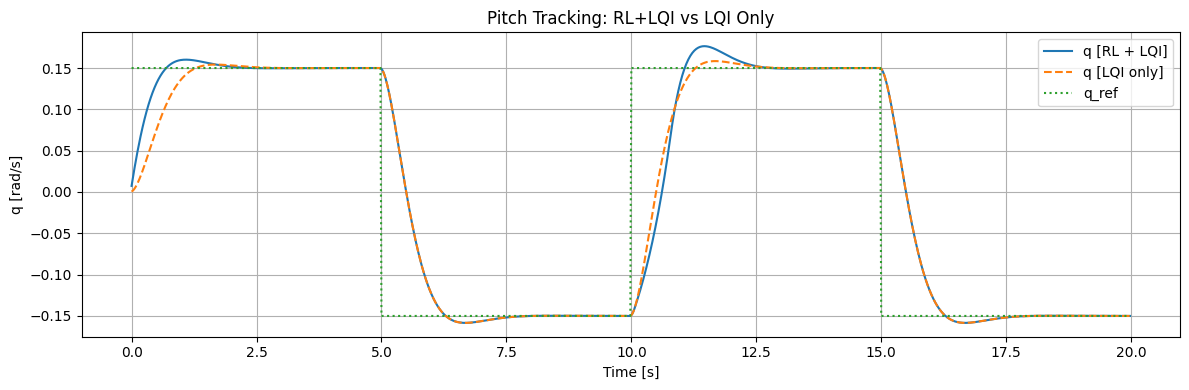

In [13]:
# Code to get q_LQI
import matplotlib.pyplot as plt

def rollout_lqi_only(env, max_t=1000):
    q_vals = []
    q_refs = []
    delta_es = []

    alpha = 0.0
    q = 0.0
    integral_error = 0.0
    dt = env.dt

    for step in range(max_t):
        t = step * dt
        q_ref = env.q_ref_square_wave(t)  # or q_ref_square_wave(t)
        integral_error += (q_ref - q) * dt
        state = np.array([alpha, q])
        delta_e = env.lqi_supervisor.get_lqi_action(state, integral_error)

        state_dot = env.A @ state + env.B * delta_e
        alpha += state_dot[0] * dt
        q += state_dot[1] * dt

        q_vals.append(q)
        q_refs.append(q_ref)
        delta_es.append(delta_e)

    return q_vals, q_refs, delta_es

# env = ShortPeriodAircraftContinuousEnv()

lqi_q_vals, lqi_q_refs, lqi_delta_es = rollout_lqi_only(env)

timesteps = np.arange(len(lqi_delta_es)) * env.dt

for i in range(len(lqi_delta_es)):
    lqi_delta_es[i] = lqi_delta_es[i] * -1

plt.figure(figsize=(12, 4))
plt.plot(timesteps, best_q_vals, label="q [RL + LQI]", linewidth=1.5)
plt.plot(timesteps, lqi_q_vals, label="q [LQI only]", linestyle="--", linewidth=1.5)
plt.plot(timesteps, best_q_refs, label="q_ref", linestyle=":", linewidth=1.5)
plt.xlabel("Time [s]")
plt.ylabel("q [rad/s]")
plt.title(f"Pitch Tracking: RL+LQI vs LQI Only")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

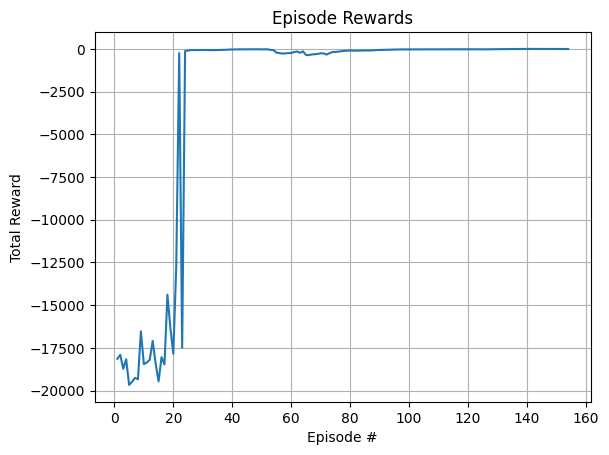

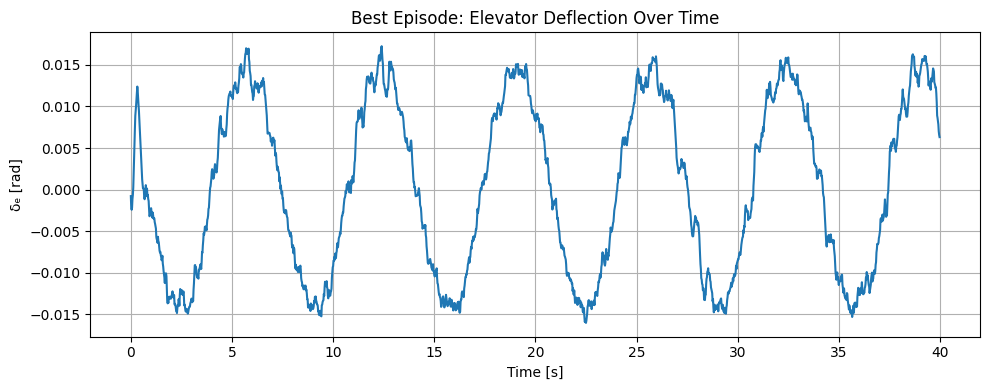

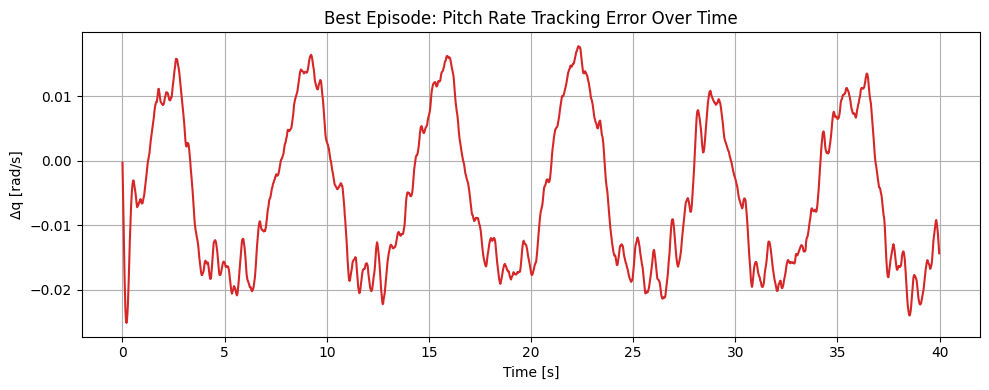

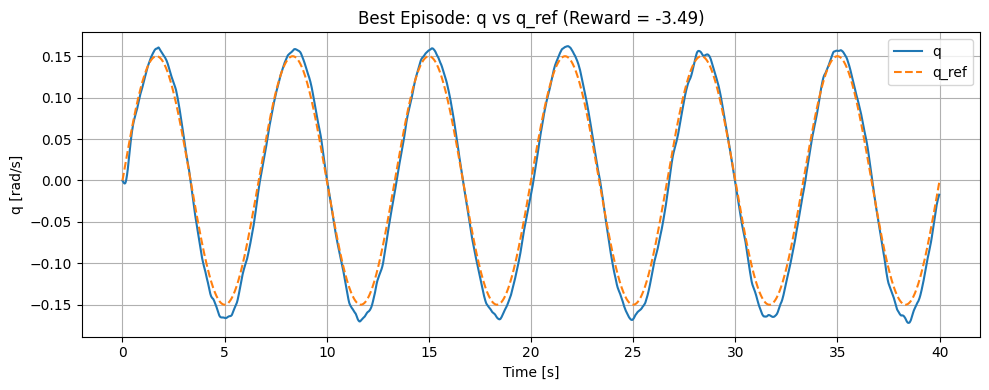

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
# Plot score curve
plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.xlabel("Episode #")
plt.ylabel("Total Reward")
plt.title("Episode Rewards")
plt.grid()

best_idx = np.argmax(scores)

dt = 0.02  # Time step
timesteps = np.arange(len(best_delta_es)) * dt

for i in range(len(best_delta_es)):
    best_delta_es[i] = best_delta_es[i] * -1


import matplotlib.pyplot as plt
import numpy as np
# 1. Elevator deflection over time
plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_delta_es, label="Elevator Deflection (δₑ)", color="tab:blue")
plt.xlabel("Time [s]")
plt.ylabel("δₑ [rad]")
plt.title("Best Episode: Elevator Deflection Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Tracking error (delta_q) over time
plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_delta_qs, label="Tracking Error (Δq = q - q_ref)", color="tab:red")
plt.xlabel("Time [s]")
plt.ylabel("Δq [rad/s]")
plt.title("Best Episode: Pitch Rate Tracking Error Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(timesteps, best_q_vals, label="q", linewidth=1.5)
plt.plot(timesteps, best_q_refs, label="q_ref", linestyle="--", linewidth=1.5)
plt.xlabel("Time [s]")
plt.ylabel("q [rad/s]")
plt.title(f"Best Episode: q vs q_ref (Reward = {best_reward:.2f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()